In [ ]:
# https://drive.google.com/file/d/1kc6XNqHZJg27KeBuoAoYj70_1rT92191/view?usp=sharing
!gdown --id 1kc6XNqHZJg27KeBuoAoYj70_1rT92191

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191
To: /content/vqa_coco_dataset.zip
100% 196M/196M [00:02<00:00, 90.6MB/s]


In [ ]:
!unzip -q vqa_coco_dataset.zip

In [ ]:
!pip install timm==0.8.17.dev0
!pip install torchtext==0.15.1
!pip install torchvision==0.16.0
!pip install torchaudio==2.1.0
!pip install torch==2.1.0
!pip install transformers==4.27.1

In [ ]:
import torch
import torch.nn as nn
import torchtext
import os
import random
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision import transforms

/opt/miniconda3/envs/thangdd_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## __Read dataset__

In [ ]:
def load_vqa_data(file_path):
    data = []
    with open(file_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            temp = line.split('\t')
            qa = temp[1].split('?')

            answer = qa[2].strip() if len(qa) == 3 else qa[1].strip()

            data_sample = {
                'image_path': temp[0][:-2],
                'question': qa[0] + '?',
                'answer': answer
            }
            data.append(data_sample)
    return data

train_data = load_vqa_data('vaq2.0.TrainImages.txt')
val_data = load_vqa_data('vaq2.0.DevImages.txt')
test_data = load_vqa_data('vaq2.0.TestImages.txt')

## __Data Preprocessing__

In [ ]:
eng = spacy.load("en_core_web_sm")

def get_tokens(data_iter):
    for sample in data_iter:
        question = sample['question']

        yield [token.text for token in eng.tokenizer(question)]


vocab = build_vocab_from_iterator(
    get_tokens(train_data),
    min_freq=2,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)
vocab.set_default_index(vocab['<unk>'])

In [ ]:
len(vocab)

1678

In [ ]:
def tokenize(question, max_seq_len):
    tokens = [token.text for token in eng.tokenizer(question)]
    sequence = [vocab[token] for token in tokens]
    if len(sequence) < max_seq_len:
        sequence += [vocab['<pad>']] * (max_seq_len - len(sequence))
    else:
        sequence = sequence[:max_seq_len]

    return sequence

In [ ]:
example_question = "Is this a picture of an apple?"
max_seq_len = 20

tokenize(example_question, max_seq_len)

[6, 5, 7, 16, 21, 75, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
def detokenize(sequence):
    idx_to_token = vocab.get_itos()
    tokens = [idx_to_token[idx] for idx in sequence if idx_to_token[idx] not in ['<pad>', '<sos>', '<eos>', '<unk>']]

    return " ".join(tokens)

In [ ]:
classes = set([sample['answer'] for sample in train_data])
label2idx = {
    cls_name: idx for idx, cls_name in enumerate(classes)
}
idx2label = {
    idx: cls_name for idx, cls_name in enumerate(classes)
}
print(idx2label)

{0: 'yes', 1: 'no'}


## __Create Pytorch dataset__

In [ ]:
class VQADataset(Dataset):
    def __init__(
        self,
        data,
        label2idx,
        max_seq_len=20,
        transform=None,
        img_dir='val2014-resised/'
    ):
        self.transform = transform
        self.data = data
        self.label2idx = label2idx
        self.max_seq_len = max_seq_len
        self.img_dir = img_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.data[index]['image_path'])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        question = self.data[index]['question']
        question = tokenize(question, self.max_seq_len)
        question = torch.tensor(question, dtype=torch.long)

        label = self.data[index]['answer']
        label = self.label2idx[label]
        label = torch.tensor(label, dtype=torch.long)

        return img, question, label


In [ ]:
data_transform = {
    'train': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.CenterCrop(size=180),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(3),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
}

In [ ]:
train_dataset = VQADataset(
    train_data,
    label2idx=label2idx,
    transform=data_transform['train']
)
val_dataset = VQADataset(
    val_data,
    label2idx=label2idx,
    transform=data_transform['val']
)
test_dataset = VQADataset(
    test_data,
    label2idx=label2idx,
    transform=data_transform['val']
)

In [ ]:
train_batch_size = 256
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

## __VQA model__

In [ ]:
class VQAModel(nn.Module):
    def __init__(
        self,
        n_classes,
        img_model_name,
        embeddding_dim,
        n_layers=2,
        hidden_size=256,
        drop_p=0.2
    ):
        super(VQAModel, self).__init__()
        self.image_encoder = timm.create_model(
            img_model_name,
            pretrained=True,
            num_classes=hidden_size,
        )

        for param in self.image_encoder.parameters():
            param.requires_grad = True

        self.embedding = nn.Embedding(len(vocab), embeddding_dim)
        self.lstm = nn.LSTM(
            input_size=embeddding_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            dropout=drop_p,
            bidirectional=True
        )

        self.fc1 = nn.Linear(hidden_size * 3, hidden_size)
        self.dropout = nn.Dropout(drop_p)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(hidden_size, n_classes)

    def forward(self, img, text):
        img_features = self.image_encoder(img)
        lstm_out, _ = self.lstm(self.embedding(text))
        text_features = lstm_out[:, -1, :]

        features = torch.cat([img_features, text_features], dim=1)
        output = self.fc1(features)
        output = self.gelu(output)
        output = self.dropout(output)
        output = self.fc2(output)

        return output

In [ ]:
n_classes = len(classes)
img_model_name = 'resnet18'
hidden_size = 256
n_layers = 2
embeddding_dim = 128
drop_p = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = VQAModel(
    n_classes=n_classes,
    img_model_name=img_model_name,
    embeddding_dim=embeddding_dim,
    n_layers=n_layers,
    hidden_size=hidden_size,
    drop_p=drop_p
).to(device)

In [ ]:
images, questions, labels = next(iter(train_loader))

model.eval()
with torch.no_grad():
    images = images.to(device)
    questions = questions.to(device)
    output = model(images, questions)
    print(output.shape)

torch.Size([256, 2])


## __Training__

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for image, question, labels in dataloader:
            image, question, labels = image.to(device), question.to(device), labels.to(device)
            outputs = model(image, question)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [ ]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (images, questions, labels) in enumerate(train_loader):
            images = images.to(device)
            questions = questions.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc}')

        scheduler.step()

    return train_losses, val_losses

In [ ]:
lr = 1e-3
epochs = 50

scheduler_step_size = epochs * 0.8
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [ ]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 0.6987	Val loss: 0.6917	Val Acc: 0.5220286885245902
EPOCH 2:	Train loss: 0.6924	Val loss: 0.6978	Val Acc: 0.4692622950819672
EPOCH 3:	Train loss: 0.6932	Val loss: 0.6949	Val Acc: 0.4912909836065574
EPOCH 4:	Train loss: 0.6909	Val loss: 0.7095	Val Acc: 0.47950819672131145
EPOCH 5:	Train loss: 0.6909	Val loss: 0.7805	Val Acc: 0.4764344262295082
EPOCH 6:	Train loss: 0.6910	Val loss: 0.6923	Val Acc: 0.524077868852459
EPOCH 7:	Train loss: 0.6891	Val loss: 0.6883	Val Acc: 0.5358606557377049
EPOCH 8:	Train loss: 0.6908	Val loss: 0.7054	Val Acc: 0.5210040983606558
EPOCH 9:	Train loss: 0.6885	Val loss: 0.6957	Val Acc: 0.5117827868852459
EPOCH 10:	Train loss: 0.6886	Val loss: 0.6898	Val Acc: 0.5358606557377049
EPOCH 11:	Train loss: 0.6884	Val loss: 0.6902	Val Acc: 0.5414959016393442
EPOCH 12:	Train loss: 0.6875	Val loss: 0.6904	Val Acc: 0.5307377049180327
EPOCH 13:	Train loss: 0.6888	Val loss: 0.6926	Val Acc: 0.5174180327868853
EPOCH 14:	Train loss: 0.6867	Val loss: 0.6958	V

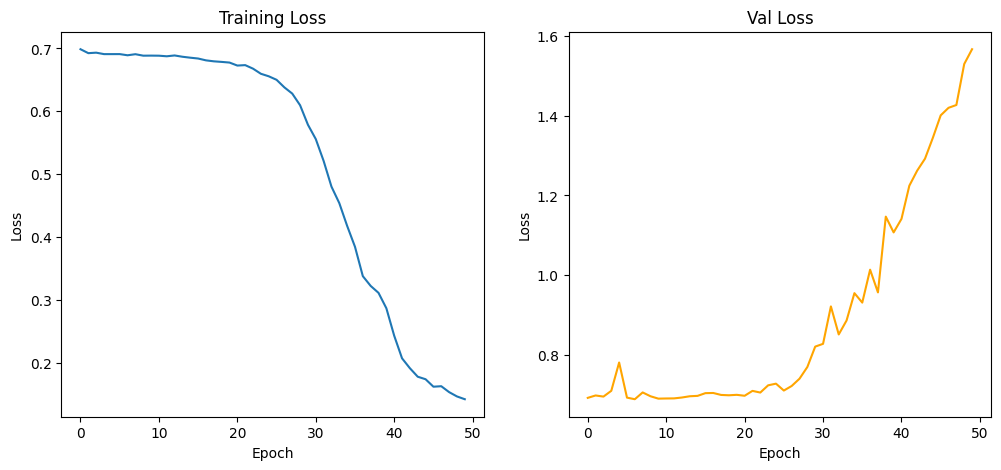

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## __Evaluation__

In [ ]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.4989754098360656
Test accuracy:  0.5084075173095944


## __Inference__

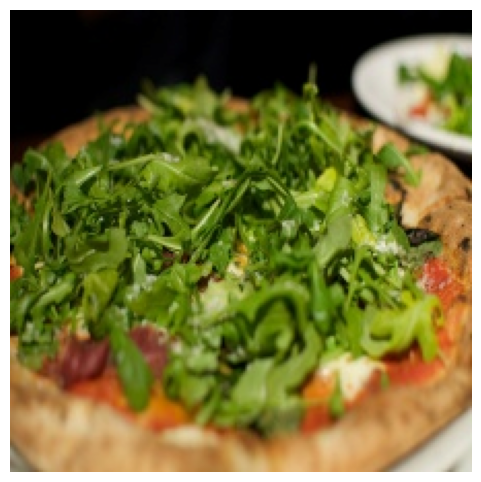

Question: Is this a pizza ?
Groundtruth: yes
Predicted: yes


In [ ]:
idx = 22
img_name = test_data[idx]['image_path']
img_path = os.path.join('val2014-resised', img_name)
question = test_data[idx]['question']
label = test_data[idx]['answer']

max_seq_len = 20
question_processed = torch.tensor(tokenize(question, max_seq_len)).unsqueeze(0).to(device)

img = Image.open(img_path).convert("RGB")
img_processed = data_transform['val'](img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(img_processed, question_processed)
    pred = torch.argmax(output, dim=1).item()

reverse_transform = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
    transforms.ToPILImage()
])
image_vis = reverse_transform(img_processed.squeeze(0).cpu())

origin_quest = detokenize(question_processed.squeeze(0).cpu().tolist())

plt.figure(figsize=(6, 6))
plt.imshow(image_vis)
plt.axis('off')
plt.show()

print(f'Question: {origin_quest}')
print(f'Groundtruth: {label}')
print(f'Predicted: {idx2label[pred]}')